# CYPLAN255
### Urban Informatics and Visualization

HIT RECORD and TRANSCRIBE

# Lecture 17 -- Network Analysis Cont'd
******
March 28, 2022

<img src="https://i.redd.it/20h18mpvreg81.jpg" width=500 align='right' title='A chest X-ray in progress at Dr. Maxime Menard’s radiology department at the Cochin hospital in Paris, France. c 1914.'>

# Agenda
1. Announcements
2. Isochrones w/ OSMnx
3. UrbanAccess
5. For next time
6. Questions


# 1. Announcements

Solution for Windows users: fresh conda environments!
1. `conda create -n <name of env> python conda` 
2. `conda config --add channels conda-forge`
3. `conda config --set channel_priority strict`
4. `conda install ipython notebook nb_conda_kernels`
5. `conda install <name of package that's giving you trouble>` (e.g. `geopandas` or `osmnx`)
6. launch Jupyter Notebook _from your new environment_

# 2. The Isochrone Tutorial from OSMnx 

99% of the code in this section was copied from [here](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb)

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

%matplotlib inline
ox.__version__

'1.1.2'

Configure the place, network type, trip times, and travel speed for analysis

In [12]:
place = {"city": "Berkeley", "state": "California"}
network_type = "walk"
trip_times = [5, 10, 15, 20, 25]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

Download the OSM network and place boundary geometries

In [13]:
G = ox.graph_from_place(place, network_type=network_type)
G = ox.project_graph(G)

bounds = ox.geocode_to_gdf(place)
bounds = ox.project_gdf(bounds)

Extract the nodes as a geodataframe to get the center-most node

In [14]:
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])

Impute an estimated walk time for each edge

In [17]:
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

## 2.2. Isochrones by Node

Assign a color to each node

In [20]:
import seaborn as sns

In [26]:
trip_times = trip_times + [30, 35,40, 45]

In [21]:
sns.color_palette("plasma", 5)

[(0.362553, 0.003243, 0.649245),
 (0.610667, 0.090204, 0.619951),
 (0.798216, 0.280197, 0.469538),
 (0.928329, 0.472975, 0.326067),
 (0.993814, 0.704741, 0.183043)]

In [27]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]

**Question:** why is this loop iterating through travel times in reverse order?

Plot the graph

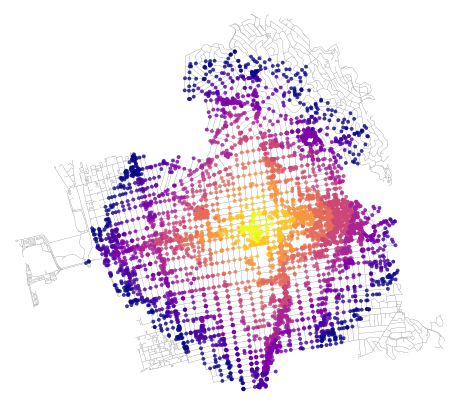

In [28]:
fig, ax = ox.plot_graph(
    G,
    bgcolor='none',
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)


## 2.3. Isochrones by Convex Hull

Generate a convex hull for each travel time bin

In [32]:
trip_times = [5,10,15,20,25]

In [33]:
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    bounding_poly = gpd.GeoSeries(bounding_poly, crs=bounds.crs).clip(bounds, keep_geom_type=True).values[0]
    isochrone_polys.append(bounding_poly)

Plot the graph and layer the convex hulls on top using matplotlib

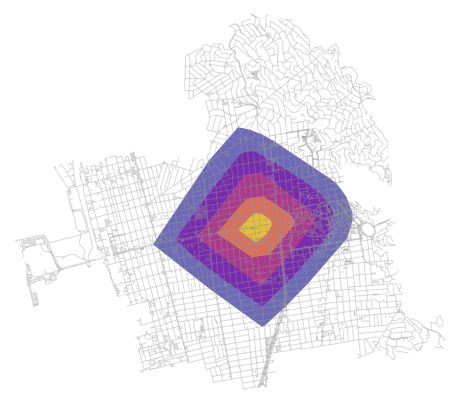

In [37]:
fig, ax = ox.plot_graph(
    G, bgcolor='none', show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## 2.4. Isochrones with Buffered Network Edges

In [38]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)

    return isochrone_polys

In [39]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)

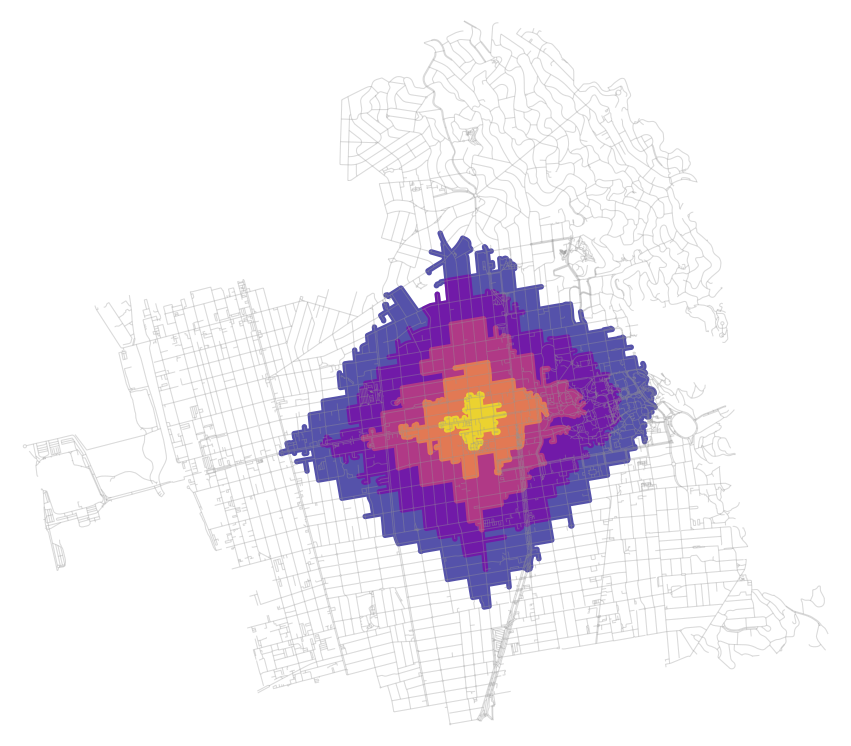

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
fig, ax = ox.plot_graph(
    G, bgcolor='none', show=False, close=False, edge_color="#999999", edge_alpha=0.2,
    node_size=0, ax=ax
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()


## Exercise 1: Drive-time Isochrones

1. Download a drive-network by specifying `network_type='drive` in `ox.graph_from_place()`
2. Use `ox.add_edge_speeds()` to add speed limit attributes to the edges.
3. Use `ox.add_edge_travel_times()` to impute the travel time along each edge based on the speed limit
4. Plot the isochrones using one of the methods we used earlier. Hint: you might want to update your travel time bins

## Exercise 2: OSMnx + Pandana

1. Extract edge and node GeoDataFrames from your OSMnx graph using `ox.graph_to_gdfs()`
2. Create a Pandana `Network()` object using `length` or `travel_time` as the impedance
3. Generate some accessibility queries!

# 3. UrbanAccess (OSM + GTFS)

Code in this section taken directly from https://github.com/UDST/urbanaccess/blob/dev/demo/simple_example.ipynb

This notebook provides a brief overview of the main functionality of UrbanAccess with examples using AC Transit and BART GTFS data and OpenStreetMap (OSM) pedestrian network data to create an integrated transit and pedestrian network for Oakland, CA for use in Pandana network accessibility queries.

**UrbanAccess on UDST:**  https://github.com/UDST/urbanaccess

**UrbanAccess documentation:**  https://udst.github.io/urbanaccess/index.html

**UrbanAccess citation:**  

`Samuel D. Blanchard and Paul Waddell, 2017, "UrbanAccess: Generalized Methodology for Measuring Regional Accessibility with an Integrated Pedestrian and Transit Network" Transportation Research Record: Journal of the Transportation Research Board, 2653: 35–44.`

### Outline

1. Imports
2. Working with GTFS data
3. Creating a transit network
4. Creating a pedestrian network
5. Creating an integrated transit and pedestrian network
6. Saving a network to disk
7. Visualizing the network
8. Adding average headways to network travel time
9. Using an UrbanAccess network with Pandana

## 3.1 Imports

In [ ]:
import matplotlib
matplotlib.use('agg')  # allows notebook to be tested in Travis

import pandas as pd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pandana as pdna
import time

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

%matplotlib inline

## 3.2. GTFS Data

### 3.2.1. Search

You can use the search function to find feeds on the GTFS Data Exchange (Note: the GTFS Data Exchange is no longer being maintained as of Summer 2016 so feeds here may be out of date)

Let's search for feeds for transit agencies in the GTFS Data Exchange that we know serve Oakland, CA: 1) Bay Area Rapid Transit District (BART) which runs the metro rail service and 2) AC Transit which runs bus services.

Let's start by finding the feed for the Bay Area Rapid Transit District (BART) by using the search term `Bay Area Rapid Transit`:

In [ ]:
gtfsfeeds.search(search_text='Bay Area Rapid Transit',
                 search_field=None,
                 match='contains')

Now that we see what can be found on the GTFS Data Exchange. Let's run this again but this time let's add the feed from your search to the feed download list

In [ ]:
gtfsfeeds.search(search_text='Bay Area Rapid Transit',
                 search_field=None,
                 match='contains',
                 add_feed=True)

### 3.2.2. Bring Your Own Data

If you know of a GTFS feed located elsewhere or one that is more up to date, you can add additional feeds located at custom URLs by adding a dictionary with the key as the name of the service/agency and the value as the URL.

Let's do this for AC Transit which also operates in Oakland, CA.

The link to their feed is here: http://www.actransit.org/planning-focus/data-resource-center/ and let's get the latest version as of June 18, 2017

In [ ]:
feeds.add_feed(add_dict={'ac transit': 'http://www.actransit.org/wp-content/uploads/GTFSJune182017B.zip'})

Note the two GTFS feeds now in your feeds object ready to download

In [ ]:
feeds.to_dict()

### 3.2.3. Downloading GTFS data

Use the download function to download all the feeds in your feeds object at once. If no parameters are specified the existing feeds object will be used to acquire the data.

By default, your data will be downloaded into the directory of this notebook in the folder: `data`

In [ ]:
gtfsfeeds.download()

### 3.2.4 Load GTFS data into an UrbanAccess transit data object

Now that we have downloaded our data let's load our individual GTFS feeds (currently a series of text files stored on disk) into a combined network of Pandas DataFrames.

- You can specify one feed or multiple feeds that are inside a root folder using the `gtfsfeed_path` parameter. If you want to aggregate multiple transit networks together, all the GTFS feeds you want to aggregate must be inside of a single root folder.
- Turn on `validation` and set a bounding box with the `remove_stops_outsidebbox` parameter turned on to ensure all your GTFS feed data are within a specified area.

Let's specify a bounding box of coordinates for the City of Oakland to subset the GTFS data to. You can generate a bounding box by going to http://boundingbox.klokantech.com/ and selecting the CSV format.

In [ ]:
validation = True
verbose = True
# bbox for City of Oakland
bbox = (-122.355881,37.632226,-122.114775,37.884725)
remove_stops_outsidebbox = True
append_definitions = True

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=None,
                                           validation=validation,
                                           verbose=verbose,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=remove_stops_outsidebbox,
                                           append_definitions=append_definitions)

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

In [ ]:
loaded_feeds.stops.head()

Note the two transit services we have aggregated into one regional table

In [ ]:
loaded_feeds.stops.unique_agency_id.unique()

Quickly view the transit stop locations

In [ ]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

In [ ]:
loaded_feeds.routes.head()

In [ ]:
loaded_feeds.stop_times.head()

In [ ]:
loaded_feeds.trips.head()

In [ ]:
loaded_feeds.calendar.head()

## 3.3. Create a transit network

Now that we have loaded and standardized our GTFS data, let's create a travel time weighted graph from the GTFS feeds we have loaded.

Create a network for weekday `monday` service between 7 am and 10 am (`['07:00:00', '10:00:00']`) to represent travel times during the AM Peak period.

Assumptions: We are using the service ids in the `calendar` file to subset the day of week, however if your feed uses the `calendar_dates` file and not the `calendar` file then you can use the `calendar_dates_lookup` parameter. This is not required for AC Transit and BART.

In [ ]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

**The UrbanAccess network object**

The output is a global `urbanaccess_network` object. This object holds the resulting graph comprised of nodes and edges for the processed GTFS network data for services operating at the day and time you specified inside of `transit_edges` and `transit_nodes`.

Let's set the global network object to a variable called `urbanaccess_net` that we can then inspect:

In [ ]:
urbanaccess_net = ua.network.ua_network

In [ ]:
urbanaccess_net.transit_edges.head()

In [ ]:
urbanaccess_net.transit_nodes.head()

In [ ]:
urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## 3.4. Create a pedestrian network

### 3.4.1. OSM Data (the walk network)

Now let's download OpenStreetMap (OSM) pedestrian street network data to produce a graph network of nodes and edges for Oakland, CA. We will use the same bounding box as before.

In [ ]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox,
                                                remove_lcn=True)

Now that we have our pedestrian network data let's create a travel time weighted graph from the pedestrian network we have loaded and add it to our existing UrbanAccess network object. We will assume a pedestrian travels on average at 3 mph.

The resulting weighted network will be added to your UrbanAccess network object inside `osm_nodes` and `osm_edges`

In [ ]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Let's inspect the results which we can access inside of the existing `urbanaccess_net` variable:

In [ ]:
urbanaccess_net.osm_nodes.head()

In [ ]:
urbanaccess_net.osm_edges.head()

In [ ]:
urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## 3.5. Create an integrated transit and pedestrian network

Now let's integrate the two networks together. The resulting graph will be added to your existing UrbanAccess network object. After running this step, your network will be ready to be used with Pandana.

The resulting integrated network will be added to your UrbanAccess network object inside `net_nodes` and `net_edges`

In [ ]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=False)

Let's inspect the results which we can access inside of the existing `urbanaccess_net` variable:

In [ ]:
urbanaccess_net.net_nodes.head()

In [ ]:
urbanaccess_net.net_edges.head()

In [ ]:
urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type'] == 'transit'].head()

## 3.6 Reading/Writing from disk

You can save the final processed integrated network `net_nodes` and `net_edges` to disk inside of a HDF5 file. By default the file will be saved to the directory of this notebook in the folder `data`

In [ ]:
ua.network.save_network(urbanaccess_network=urbanaccess_net,
                        filename='final_net.h5',
                        overwrite_key = True)

You can load an existing processed integrated network HDF5 file from disk into a UrbanAccess network object.

In [ ]:
urbanaccess_net = ua.network.load_network(filename='final_net.h5')

## 3.7 Visualize the network

You can visualize the network you just created using basic UrbanAccess plot functions

### 3.7.1. Integrated network

In [ ]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=1.1, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

### 3.7.2. Integrated network by travel time

Use the `col_colors` function to color edges by travel time. In this case the darker red the higher the travel times.

Note the ability to see AC Transit's major bus arterial routes (in darker red) and transfer locations and BART rail network (rail stations are visible by the multiple bus connections at certain junctions in the network most visible in downtown Oakland at 19th, 12th Street, and Lake Merritt stations and Fruitvale and Coliseum stations) with the underlying pedestrian network. Downtown Oakland is located near the white cutout in the northeast middle section of the network which represents Lake Merritt.

In [ ]:
edgecolor = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor, edge_linewidth=1, edge_alpha=0.7,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

Let's zoom in closer to downtown Oakland using a new smaller extent bbox. Note the bus routes on the major arterials and the BART routes from station to station.

In [ ]:
edgecolor = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=(-122.282295, 37.795, -122.258434, 37.816022),
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor, edge_linewidth=1, edge_alpha=0.7,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

### 3.7.3. Transit network

You can also slice the network by network type

In [ ]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type']=='transit'],
                 bbox=None,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

### 3.7.4. Pedestrian network

In [ ]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type']=='walk'],
                 bbox=None,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

### 3.7.5. Transit network: AC Transit Route 51A

You can slice the network using any attribute in edges. In this case let's examine one route for AC Transit route 51A.

Looking at what routes are in the network for 51A we see route id: `51A-141_ac_transit`

In [ ]:
urbanaccess_net.net_edges['unique_route_id'].unique()

In [ ]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges[urbanaccess_net.net_edges['unique_route_id']=='51A-141_ac_transit'],
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

### 3.7.6. Transit network: BART network

We can also slice the data by agency. In this case let's view all BART routes.

Looking at what agencies are in the network for BART we see agency id: `bay_area_rapid_transit`

In [ ]:
urbanaccess_net.net_edges['unique_agency_id'].unique()

In [ ]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges[urbanaccess_net.net_edges['unique_agency_id']=='bay_area_rapid_transit'],
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

## 3.8. Add average headways to network travel time

### 3.8.1. Calculate route stop level headways

The network we have generated so far only contains pure travel times. UrbanAccess allows for the calculation of and addition of route stop level average headways to the network. This is used as a proxy for passenger wait times at stops and stations. The route stop level average headway are added to the pedestrian to transit connector edges.

Let's calculate headways for the same AM Peak time period. Statistics on route stop level headways will be added to your GTFS transit data object inside of `headways`

In [ ]:
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['07:00:00','10:00:00'])

In [ ]:
loaded_feeds.headways.head()

### 3.8.2. Add the route stop level average headways to your integrated network

Now that headways have been calculated and added to your GTFS transit feed object, you can use them to generate a new integrated network that incorporates the headways within the pedestrian to transit connector edge travel times.

In [ ]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

### 3.8.3. Integrated network by travel time with average headways

In [ ]:
edgecolor = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor, edge_linewidth=1, edge_alpha=0.7,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

## 3.9. Using an UrbanAccess network with Pandana

Pandana (Pandas Network Analysis) is a tool to compute network accessibility metrics.

Now that we have an integrated transit and pedestrian network that has been formatted for use with Pandana, we can now use Pandana right away to compute accessibility metrics.

There are a couple of things to remember about UrbanAccess and Pandana:
- UrbanAccess generates by default a one way network. One way means there is an explicit edge for each direction in the edge table. Where applicable, it is important to set any Pandana `two_way` parameters to `False` (they are `True` by default) to indicate that the network is a one way network.
- As of Pandana v0.3.0, `node ids` and `from` and `to` columns in your network must be integer type and not string. UrbanAccess automatically generates both string and integer types so use the `from_int` and `to_int` columns in edges and the index in nodes `id_int`.
- UrbanAccess by default will generate edge weights that represent travel time in units of minutes.

For more on Pandana see the:

**Pandana repo:** https://github.com/UDST/pandana 

**Pandana documentation:** http://udst.github.io/pandana/

### 3.9.1. Load Census block data

Let's load 2010 Census block data for the 9 county Bay Area. Note: These data have been processed from original Census and LEHD data.

The data is located in the `demo` folder on the repo with this notebook.

In [ ]:
blocks = pd.read_hdf('../data/bay_area_demo_data.h5','blocks')
# remove blocks that contain all water
blocks = blocks[blocks['square_meters_land'] != 0]
print('Total number of blocks: {:,}'.format(len(blocks)))
blocks.head()

Let's subset the Census data to just be the bounding box for Oakland

In [ ]:
lng_max, lat_min, lng_min, lat_max = bbox
outside_bbox = blocks.loc[~(((lng_max < blocks["x"]) & (blocks["x"] < lng_min)) & ((lat_min < blocks["y"]) & (blocks["y"] < lat_max)))]
blocks_subset = blocks.drop(outside_bbox.index)
print('Total number of subset blocks: {:,}'.format(len(blocks_subset)))

In [ ]:
blocks_subset.plot(kind='scatter', x='x', y='y', s=0.1)

### 3.9.2. Initialize the Pandana network

Let's initialize our Pandana network object using our transit and pedestrian network we created. Note: the `from_int` and `to_int` as well as the `twoway=False` denoting this is a explicit one way network.

In [ ]:
s_time = time.time()
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Now let's set our blocks on to the network

In [ ]:
blocks_subset['node_id'] = transit_ped_net.get_node_ids(blocks_subset['x'], blocks_subset['y'])

### 3.9.3. Calculate cumulative accessibility

Now let's compute an accessibility metric, in this case a cumulative accessibility metric. See Pandana for other metrics that can be calculated. 

Let's set the block variables we want to use as our accessibly metric on the Pandana network. In this case let's use `jobs`

In [ ]:
transit_ped_net.set(blocks_subset.node_id, variable = blocks_subset.jobs, name='jobs')

Now let's run an cumulative accessibility query using our network and the jobs variable for three different travel time thresholds: 15, 30, 45 minutes.

Note: Depending on network size, radius threshold, computer processing power, and whether or not you are using multiple cores the compute process may take some time.

In [ ]:
s_time = time.time()
jobs_45 = transit_ped_net.aggregate(45, type='sum', decay='linear', name='jobs')
jobs_30 = transit_ped_net.aggregate(30, type='sum', decay='linear', name='jobs')
jobs_15 = transit_ped_net.aggregate(15, type='sum', decay='linear', name='jobs')
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Quickly visualize the accessibility query results. As expected, note that a travel time of 15 minutes results in a lower number of jobs accessible at each network node.

In [ ]:
print(jobs_45.head())
print(jobs_30.head())
print(jobs_15.head())

### 3.9.4. Jobs accessible within 15 minutes

Note how the radius of the number of jobs accessible expands as the time threshold increases where high accessibility is indicated in dark red. You can easily see downtown Oakland has the highest accessibility due to a convergence of transit routes and because downtown is where the majority of jobs in the area are located. Other high accessibility areas are visible elsewhere directly adjacent to BART metro rail stations of West Oakland, Fruitvale, and Coliseum and AC Transit bus routes on the main arterial road corridors.

In [ ]:
s_time = time.time()

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=jobs_15, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

print('Took {:,.2f} seconds'.format(time.time() - s_time))

### 3.9.5. Jobs accessible within 30 minutes

In [ ]:
s_time = time.time()

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=jobs_30, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

print('Took {:,.2f} seconds'.format(time.time() - s_time))

### 3.9.6. Jobs accessible within 45 minutes

In [ ]:
s_time = time.time()

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=jobs_45, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

print('Took {:,.2f} seconds'.format(time.time() - s_time))

# 4. Questions?

# 5. For next time 

### Readings
1. MAUP
   - https://sci-hubtw.hkvisa.net/10.1016/b978-008044910-4.00475-2
   - https://www.gislounge.com/modifiable-areal-unit-problem-gis/
2. How to lie with Maps
   - https://www.nytimes.com/interactive/2020/10/30/opinion/election-results-maps.html
3. Choropleth maps
   - https://geographicdata.science/book/notebooks/05_choropleth.html
   - https://www.axismaps.com/guide/choropleth
4. Dot Density Maps
  - https://www.axismaps.com/guide/dot-density
  - http://andrewgaidus.com/Dot_Density_County_Maps/